## 1. 패키지 및 데이터 준비

In [133]:
# 패키지 로딩하기
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import os
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab
import gensim
%matplotlib inline

In [134]:
# 데이터 불러오기
train_data = pd.read_table("~/aiffel/sentiment_classification/ratings_train.txt")
test_data  = pd.read_table("~/aiffel/sentiment_classification/ratings_test.txt")

In [135]:
# train_data 확인하기
train_data.shape

(150000, 3)

In [136]:
# test_data 확인하기
test_data.shape

(50000, 3)

## 2. 데이터 함수 만들기

In [137]:
# tokenizer 만들기
tokenizer = Mecab()

In [138]:
# 불용어 설정하기
stopwords = ["의", "가", "이", "은", "들", "는", "좀", "잘", "걍", "과", "도", "를", "으로", "자", "에", "와", "한", "하다"]

In [139]:
# load_data 함수 만들기
def load_data(train_data, test_data, num_words = 10000):
    train_data.drop_duplicates(subset = ["document"], inplace = True) # train_data 중복 제거
    test_data.drop_duplicates(subset  = ["document"], inplace = True) # test_data  중복 제거
    train_data = train_data.dropna()                                  # train_data 결측치 제거
    test_data  = test_data.dropna()                                   # test_data  결측치 제거
    
    X_train = []
    for sentence in train_data["document"]:
        temp_X = tokenizer.morphs(sentence)                           # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]   # 불용어 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data["document"]:
        temp_X = tokenizer.morphs(sentence)                           # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]   # 불용어 제거
        X_test.append(temp_X)
        
    words         = np.concatenate(X_train).tolist()                  # 데이터 결합, 리스트로 전환
    counter       = Counter(words)
    counter       = counter.most_common(1000 - 4)                     # 갯수가 많은 데이터순으로 정렬
    vocab         = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test  = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data["label"])), X_test, np.array(list(test_data["label"])), word_to_index

index_to_word = {index : word for word, index in word_to_index.items()}

In [140]:
# 데이터 나누기
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [141]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 모든 문장은 <BOS>로 시작하게 만듬.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index["<BOS>"] + [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in sentence.split()]]

# 여러개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode 해주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return "".join(index_to_word[index] if index in index_to_word else "<UNK>" for index in encoded_sentence[1:]) # <BOS>는 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 데이터 분석 및 가공

In [142]:
# pad_sequences를 위한 word vector의 길이 구하기
total_data_text = list(X_train) + list(X_test)

# text_data 문장길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균, 최대값, 표준편차 구하기
print("평균 :",     np.mean(num_tokens))
print("최대값 :",   np.max(num_tokens))
print("표준편차 :", np.std(num_tokens))

평균 : 15.969376315021577
최대값 : 116
표준편차 : 12.843535456326455


In [143]:
# maxlen을 정의하고 그 길이 안에 데이터가 몇 %가 있는지를 본 뒤 padding할 길이를 정한다.
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen     = int(max_tokens)
print("pad_sequence maxlen :", maxlen)
print("전체 문장의 {}%가 maxlen 이내에 포함됩니다.".format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))

pad_sequence maxlen : 54
전체 문장의 97.20946661956906%가 maxlen 이내에 포함됩니다.


In [144]:
# 적절한 maxlen을 구했으니, maxlen에 맞춰 패딩하기
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value = word_to_index["<PAD>"], padding = "pre", maxlen = maxlen)
X_test  = tf.keras.preprocessing.sequence.pad_sequences(X_test,  value = word_to_index["<PAD>"], padding = "pre", maxlen = maxlen)
print("X_train :", X_train.shape)
print("X_test :",  X_test.shape)

X_train : (146182, 54)
X_test : (49157, 54)


## 4. 모델구성 및 validation_set 구성

### 4_1. 첫 번째 모델 : 1-D CNN

In [145]:
vocab_size      = len(word_to_index) # 어휘 사전의 크기
word_vector_dim = 54                 # 워드 벡터의 차원수(하이퍼 파라미터)

In [146]:
# model 만들기
tf_model = tf.keras.Sequential()
# 계층 쌓기
tf_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
tf_model.add(tf.keras.layers.Conv1D(32, 9, activation = "relu")) # 변경가능
tf_model.add(tf.keras.layers.MaxPooling1D(5))
tf_model.add(tf.keras.layers.Conv1D(32, 9, activation = "relu")) # 변경가능
tf_model.add(tf.keras.layers.GlobalMaxPooling1D())
tf_model.add(tf.keras.layers.Dense(8, activation = "relu"))      # 변경가능
tf_model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))   # output이 긍정, 부정이므로 1

# model 확인하기
tf_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 54)          54000     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          15584     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          9248      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

### 4_2. 두 번째 모델 : RNN

In [147]:
vocab_size      = len(word_to_index) # 어휘 사전의 크기
word_vector_dim = 54                 # 워드 벡터의 차원수(하이퍼 파라미터)

In [148]:
# model 만들기
tf_model2 = tf.keras.Sequential()
# 계층 쌓기
tf_model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
tf_model2.add(tf.keras.layers.LSTM(32)) # 변경가능
tf_model2.add(tf.keras.layers.Dense(32, activation = "relu"))    # 변경가능
tf_model2.add(tf.keras.layers.Dense(1,  activation = "sigmoid")) # 변경가능

# model 확인하기
tf_model2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 54)          54000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                11136     
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 66,225
Trainable params: 66,225
Non-trainable params: 0
_________________________________________________________________


### 4_3. 세 번째 모델 : GlobalMaxPooling1D   
#### 전체 문장 중 하나의 가장 중요한 단어만 feature로 추출하여 그것으로 긍정 / 부정을 평가하는 방식

In [149]:
vocab_size      = len(word_to_index) # 어휘 사전의 크기
word_vector_dim = 54                 # 워드 벡터의 차원수(하이퍼 파라미터)

In [150]:
# model 만들기
tf_model3 = tf.keras.Sequential()
# 계층 쌓기
tf_model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
tf_model3.add(tf.keras.layers.GlobalMaxPooling1D())
tf_model3.add(tf.keras.layers.Dense(32, activation = "relu"))    # 변경가능
tf_model3.add(tf.keras.layers.Dense(1,  activation = "sigmoid")) # 변경가능

# model 확인하기
tf_model3.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 54)          54000     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 54)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1760      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 55,793
Trainable params: 55,793
Non-trainable params: 0
_________________________________________________________________


In [151]:
# validation_set 분리 : 46182개 (training_set을 깔끔하게 100,000으로 하려고)
X_val = X_train[:46182]
y_val = y_train[:46182]

print("X_val :", X_val.shape)
print("y_val :", y_val.shape)

X_val : (46182, 54)
y_val : (46182,)


In [152]:
# 나머지는 training_set으로 구성
real_x_train = X_train[46182:]
real_y_train = y_train[46182:]

print("x_train :", real_x_train.shape)
print("y_train :", real_y_train.shape)

x_train : (100000, 54)
y_train : (100000,)


## 5. 모델 훈련 개시

### 5_1. 첫 번째 모델 훈련 개시

In [153]:
tf_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy", metrics = ["accuracy"])

history = tf_model.fit(real_x_train, real_y_train, epochs = 20, batch_size = 512, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/20
196/196 [==============================] - 4s 20ms/step - loss: 0.5127 - accuracy: 0.7371 - val_loss: 0.4121 - val_accuracy: 0.8055
Epoch 2/20
196/196 [==============================] - 1s 7ms/step - loss: 0.4078 - accuracy: 0.8083 - val_loss: 0.3969 - val_accuracy: 0.8133
Epoch 3/20
196/196 [==============================] - 1s 6ms/step - loss: 0.3877 - accuracy: 0.8198 - val_loss: 0.3898 - val_accuracy: 0.8165
Epoch 4/20
196/196 [==============================] - 1s 6ms/step - loss: 0.3697 - accuracy: 0.8286 - val_loss: 0.3815 - val_accuracy: 0.8198
Epoch 5/20
196/196 [==============================] - 1s 6ms/step - loss: 0.3525 - accuracy: 0.8384 - val_loss: 0.3808 - val_accuracy: 0.8203
Epoch 6/20
196/196 [==============================] - 1s 6ms/step - loss: 0.3345 - accuracy: 0.8480 - val_loss: 0.3804 - val_accuracy: 0.8202
Epoch 7/20
196/196 [==============================] - 1s 7ms/step - loss: 0.3154 - accuracy: 0.8590 - val_loss: 0.3877 - val_accuracy: 0.8193
Epoch

### 5_2. 두 번째 모델 훈련 개시

In [154]:
tf_model2.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy", metrics = ["accuracy"])

history2 = tf_model2.fit(real_x_train, real_y_train, epochs = 20, batch_size = 512, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/20
196/196 [==============================] - 2s 9ms/step - loss: 0.4789 - accuracy: 0.7739 - val_loss: 0.4062 - val_accuracy: 0.8083
Epoch 2/20
196/196 [==============================] - 2s 8ms/step - loss: 0.4005 - accuracy: 0.8146 - val_loss: 0.3905 - val_accuracy: 0.8184
Epoch 3/20
196/196 [==============================] - 2s 8ms/step - loss: 0.3911 - accuracy: 0.8190 - val_loss: 0.3853 - val_accuracy: 0.8195
Epoch 4/20
196/196 [==============================] - 1s 7ms/step - loss: 0.3820 - accuracy: 0.8230 - val_loss: 0.3788 - val_accuracy: 0.8226
Epoch 5/20
196/196 [==============================] - 2s 8ms/step - loss: 0.3751 - accuracy: 0.8258 - val_loss: 0.3780 - val_accuracy: 0.8229
Epoch 6/20
196/196 [==============================] - 1s 7ms/step - loss: 0.3684 - accuracy: 0.8304 - val_loss: 0.3761 - val_accuracy: 0.8250
Epoch 7/20
196/196 [==============================] - 1s 7ms/step - loss: 0.3610 - accuracy: 0.8331 - val_loss: 0.3690 - val_accuracy: 0.8284
Epoch 

### 5_3. 세 번째 모델 훈련 개시

In [155]:
tf_model3.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy", metrics = ["accuracy"])

history3 = tf_model3.fit(real_x_train, real_y_train, epochs = 20, batch_size = 512, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/20
196/196 [==============================] - 1s 5ms/step - loss: 0.5306 - accuracy: 0.7690 - val_loss: 0.3998 - val_accuracy: 0.8155
Epoch 2/20
196/196 [==============================] - 1s 5ms/step - loss: 0.3933 - accuracy: 0.8204 - val_loss: 0.3888 - val_accuracy: 0.8213
Epoch 3/20
196/196 [==============================] - 1s 5ms/step - loss: 0.3784 - accuracy: 0.8278 - val_loss: 0.3887 - val_accuracy: 0.8228
Epoch 4/20
196/196 [==============================] - 1s 5ms/step - loss: 0.3679 - accuracy: 0.8328 - val_loss: 0.3840 - val_accuracy: 0.8243
Epoch 5/20
196/196 [==============================] - 1s 5ms/step - loss: 0.3576 - accuracy: 0.8394 - val_loss: 0.3833 - val_accuracy: 0.8249
Epoch 6/20
196/196 [==============================] - 1s 5ms/step - loss: 0.3476 - accuracy: 0.8454 - val_loss: 0.3848 - val_accuracy: 0.8250
Epoch 7/20
196/196 [==============================] - 1s 5ms/step - loss: 0.3375 - accuracy: 0.8507 - val_loss: 0.3853 - val_accuracy: 0.8253
Epoch 

## 6. Loss, Accuracy 그래프 시각화

### 6_1. 첫 번째 모델 그래프 시각화

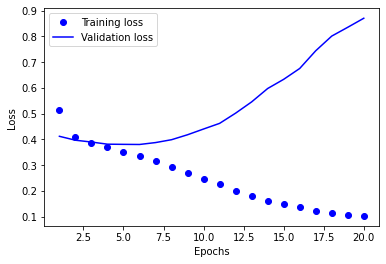

In [156]:
# Loss 그래프 시각화
train_accuracy = history.history["accuracy"]
val_accuracy   = history.history["val_accuracy"]
train_loss     = history.history["loss"]
val_loss       = history.history["val_loss"]

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_loss, "bo", label = "Training loss")   # train_loss는 파란색 점 표시
plt.plot(epochs, val_loss,   "b",  label = "Validation loss") # val loss는 파란색 실선 표시
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

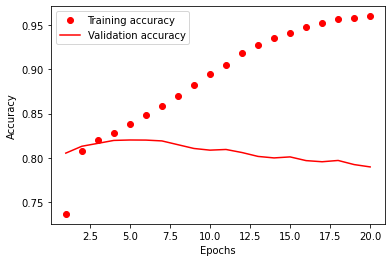

In [157]:
# Accuracy 그래프 시각화
plt.plot(epochs, train_accuracy, "ro", label = "Training accuracy")   # train_accuracy는 빨간색 점 표시
plt.plot(epochs, val_accuracy,   "r",  label = "Validation accuracy") # val_accuracy는 빨간색 실선 표시
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 6_2. 두 번째 모델 그래프 시각화

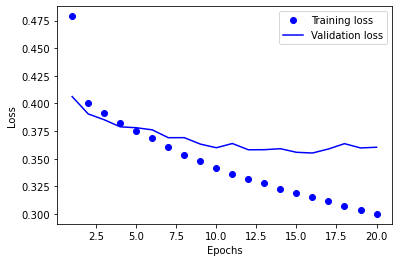

In [158]:
# Loss 그래프 시각화
train_accuracy2 = history2.history["accuracy"]
val_accuracy2   = history2.history["val_accuracy"]
train_loss2     = history2.history["loss"]
val_loss2       = history2.history["val_loss"]

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_loss2, "bo", label = "Training loss")   # train_loss는 파란색 점 표시
plt.plot(epochs, val_loss2,   "b",  label = "Validation loss") # val loss는 파란색 실선 표시
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

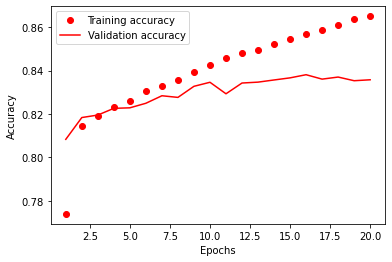

In [159]:
# Accuracy 그래프 시각화
plt.plot(epochs, train_accuracy2, "ro", label = "Training accuracy")   # train_accuracy는 빨간색 점 표시
plt.plot(epochs, val_accuracy2,   "r",  label = "Validation accuracy") # val_accuracy는 빨간색 실선 표시
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 6_3. 세 번째 모델 그래프 시각화

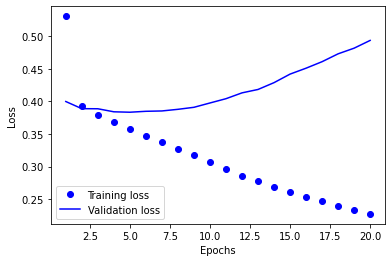

In [160]:
# Loss 그래프 시각화
train_accuracy3 = history3.history["accuracy"]
val_accuracy3   = history3.history["val_accuracy"]
train_loss3     = history3.history["loss"]
val_loss3       = history3.history["val_loss"]

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_loss3, "bo", label = "Training loss")   # train_loss는 파란색 점 표시
plt.plot(epochs, val_loss3,   "b",  label = "Validation loss") # val loss는 파란색 실선 표시
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

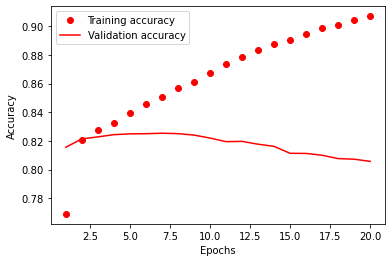

In [161]:
# Accuracy 그래프 시각화
plt.plot(epochs, train_accuracy3, "ro", label = "Training accuracy")   # train_accuracy는 빨간색 점 표시
plt.plot(epochs, val_accuracy3,   "r",  label = "Validation accuracy") # val_accuracy는 빨간색 실선 표시
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 7. 학습된 Embedding 레이어 분석

### 7_1. 첫 번째 모델의 Embedding 레이어 분석

In [162]:
embedding_layer = tf_model.layers[0]
weights         = embedding_layer.get_weights()[0]
print("Weights :", weights.shape) # shape : (vocab_size, embedding_dim)

Weights : (1000, 54)


### 7_2. 두 번째 모델의 Embedding 레이어 분석

In [163]:
embedding_layer2 = tf_model2.layers[0]
weights2         = embedding_layer.get_weights()[0]
print("Weights :", weights2.shape) # shape : (vocab_size, embedding_dim)

Weights : (1000, 54)


### 7_3. 세 번째 모델의 Embedding 레이어 분석

In [164]:
embedding_layer3 = tf_model3.layers[0]
weights3         = embedding_layer.get_weights()[0]
print("Weights :", weights3.shape) # shape : (vocab_size, embedding_dim)

Weights : (1000, 54)


## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [165]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/ko/ko.bin'
word2vec      = gensim.models.Word2Vec.load(word2vec_path)

In [166]:
word2vec.wv.vectors.shape

(30185, 200)

In [180]:
vocab_size, _   = word2vec.wv.vectors.shape # 어휘사전 크기, 워드벡터 차원수
word_vector_dim = 54

### 8_1. 첫 번째 모델 : 1-D CNN

In [190]:
vocab_size, _   = word2vec.wv.vectors.shape # 어휘사전 크기, 워드벡터 차원수
word_vector_dim = 54

In [188]:
# model 만들기
word2vec_model = tf.keras.Sequential()
# 계층 쌓기
word2vec_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,), weights = [word2vec.wv.vectors]))
word2vec_model.add(tf.keras.layers.Conv1D(256, 100, activation = "relu"))
word2vec_model.add(tf.keras.layers.MaxPooling1D(20))
word2vec_model.add(tf.keras.layers.Conv1D(256, 100, activation = "relu"))
word2vec_model.add(tf.keras.layers.GlobalMaxPooling1D())
word2vec_model.add(tf.keras.layers.Dense(16, activation = "relu"))
word2vec_model.add(tf.keras.layers.Dense(1,  activation = "sigmoid"))

# model 확인하기
word2vec_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 200)         6037000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 256)         5120256   
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 256)         6553856   
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_39 (Dense)             (None, 1)               

### 8_2. 두 번째 모델 : RNN

In [183]:
vocab_size, _   = word2vec.wv.vectors.shape # 어휘사전 크기, 워드벡터 차원수
word_vector_dim = 54

In [175]:
# model 만들기
word2vec_model2 = tf.keras.Sequential()
# 계층 쌓기
word2vec_model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,), weights = [word2vec.wv.vectors]))
word2vec_model2.add(tf.keras.layers.LSTM(256))
word2vec_model2.add(tf.keras.layers.Dense(16, activation = "relu"))
word2vec_model2.add(tf.keras.layers.Dense(1,  activation = "sigmoid"))

# model 확인하기
word2vec_model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 200)         6037000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_34 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 6,509,097
Trainable params: 6,509,097
Non-trainable params: 0
_________________________________________________________________


### 8_3. 세 번째 모델 : GlobalMaxPooling1D

In [184]:
vocab_size, _   = word2vec.wv.vectors.shape # 어휘사전 크기, 워드벡터 차원수
word_vector_dim = 54

In [176]:
# model 만들기
word2vec_model3 = tf.keras.Sequential()
# 계층 쌓기
word2vec_model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,), weights = [word2vec.wv.vectors]))
word2vec_model3.add(tf.keras.layers.GlobalMaxPooling1D())
word2vec_model3.add(tf.keras.layers.Dense(16, activation = "relu"))
word2vec_model3.add(tf.keras.layers.Dense(1,  activation = "sigmoid"))

# model 확인하기
word2vec_model3.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 200)         6037000   
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                3216      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 17        
Total params: 6,040,233
Trainable params: 6,040,233
Non-trainable params: 0
_________________________________________________________________


#### 훈련 시작

In [189]:
# model 1
word2vec_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy", metrics = ["accuracy"])

history4 = word2vec_model.fit(real_x_train, real_y_train, epochs = 20, batch_size = 512, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/20


ValueError: in user code:

    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:277 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py:207 call
        outputs = self._convolution_op(inputs, self.kernel)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:1106 __call__
        return self.conv_op(inp, filter)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:638 __call__
        return self.call(inp, filter)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:237 __call__
        name=self.name)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:226 _conv1d
        name=name)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:574 new_func
        return func(*args, **kwargs)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:574 new_func
        return func(*args, **kwargs)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:1663 conv1d
        name=name)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py:969 conv2d
        data_format=data_format, dilations=dilations, name=name)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 100 from 54 for '{{node sequential_20/conv1d_16/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_20/conv1d_16/conv1d/ExpandDims, sequential_20/conv1d_16/conv1d/ExpandDims_1)' with input shapes: [?,1,54,200], [1,100,200,256].


In [179]:
real_x_train.shape

(100000, 54)

In [186]:
# model 2
word2vec_model2.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy", metrics = ["accuracy"])

history5 = word2vec_model2.fit(real_x_train, real_y_train, epochs = 20, batch_size = 512, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/20
196/196 [==============================] - 11s 57ms/step - loss: 0.4747 - accuracy: 0.7625 - val_loss: 0.3977 - val_accuracy: 0.8132
Epoch 2/20
196/196 [==============================] - 11s 55ms/step - loss: 0.3740 - accuracy: 0.8292 - val_loss: 0.3731 - val_accuracy: 0.8291
Epoch 3/20
196/196 [==============================] - 11s 55ms/step - loss: 0.3402 - accuracy: 0.8448 - val_loss: 0.3602 - val_accuracy: 0.8326
Epoch 4/20
196/196 [==============================] - 11s 56ms/step - loss: 0.3093 - accuracy: 0.8605 - val_loss: 0.3617 - val_accuracy: 0.8333
Epoch 5/20
196/196 [==============================] - 11s 55ms/step - loss: 0.2788 - accuracy: 0.8765 - val_loss: 0.3641 - val_accuracy: 0.8327
Epoch 6/20
196/196 [==============================] - 11s 57ms/step - loss: 0.2454 - accuracy: 0.8918 - val_loss: 0.3888 - val_accuracy: 0.8354
Epoch 7/20
196/196 [==============================] - 11s 54ms/step - loss: 0.2089 - accuracy: 0.9092 - val_loss: 0.4182 - val_accuracy:

In [191]:
# model 3
word2vec_model3.compile(optimizer = tf.keras.optimizers.Adam(), loss = "binary_crossentropy", metrics = ["accuracy"])

history6 = word2vec_model3.fit(real_x_train, real_y_train, epochs = 20, batch_size = 512, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/20
196/196 [==============================] - 8s 39ms/step - loss: 0.6837 - accuracy: 0.5905 - val_loss: 0.6256 - val_accuracy: 0.6557
Epoch 2/20
196/196 [==============================] - 8s 39ms/step - loss: 0.5835 - accuracy: 0.7011 - val_loss: 0.5370 - val_accuracy: 0.7332
Epoch 3/20
196/196 [==============================] - 8s 40ms/step - loss: 0.5078 - accuracy: 0.7505 - val_loss: 0.4774 - val_accuracy: 0.7689
Epoch 4/20
196/196 [==============================] - 8s 40ms/step - loss: 0.4625 - accuracy: 0.7797 - val_loss: 0.4494 - val_accuracy: 0.7848
Epoch 5/20
196/196 [==============================] - 7s 38ms/step - loss: 0.4391 - accuracy: 0.7937 - val_loss: 0.4346 - val_accuracy: 0.7948
Epoch 6/20
196/196 [==============================] - 7s 38ms/step - loss: 0.4245 - accuracy: 0.8019 - val_loss: 0.4275 - val_accuracy: 0.7986
Epoch 7/20
196/196 [==============================] - 8s 39ms/step - loss: 0.4146 - accuracy: 0.8073 - val_loss: 0.4200 - val_accuracy: 0.8043

## 회고

In [ ]:
# 요번 과제는 너무 어려운 것 같음. 과제로는 처음으로 모르는 개념(선행 공부 해보지도 않은)이였는데 노드만 가지고 코드까지 짤 수 있도록 이해하는 것이
# 힘들었음. 하지만 구글링을 열심히 해도 힘들었던 것을 보면 개념 자체가 어려운것 같기도 함.

# 코드를 짜면서 모델생성까지는 어찌어찌 했지만 내가 무엇을 하는지 잘 모른 상태로 진행한 것 같음.

# 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
# 한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.
# https://github.com/Kyubyong/wordvectors
# 이라고 써있는데 막상 안에 들어가서 어떻게 얻을 수 있는지를 몰라서 구글링을 통해 얻었음.(같은것인지 모르겠지만...)

# 임베딩 레이어 분석에서 나오는 숫자들이 어떻게 나오면 어떻게 해석해야하는지를 모르겠음.

# 전체적으로 엉망인...과제인 것 같음. 나중에 다시 도전해야 할 것 같음.